<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TODO" data-toc-modified-id="TODO-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TODO</a></span></li><li><span><a href="#Event-mode-data-acquisition" data-toc-modified-id="Event-mode-data-acquisition-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Event mode data acquisition</a></span></li><li><span><a href="#Generating-some-test-data" data-toc-modified-id="Generating-some-test-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generating some test data</a></span><ul class="toc-item"><li><span><a href="#Testing-it-out" data-toc-modified-id="Testing-it-out-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Testing it out</a></span><ul class="toc-item"><li><span><a href="#1D" data-toc-modified-id="1D-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>1D</a></span></li></ul></li><li><span><a href="#Deviation" data-toc-modified-id="Deviation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Deviation</a></span></li></ul></li><li><span><a href="#Bayesian" data-toc-modified-id="Bayesian-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bayesian</a></span><ul class="toc-item"><li><span><a href="#2D" data-toc-modified-id="2D-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>2D</a></span></li><li><span><a href="#3D" data-toc-modified-id="3D-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>3D</a></span></li></ul></li><li><span><a href="#Fitting-Gaussian-Mixture-Models-with-Expectation-Maximization" data-toc-modified-id="Fitting-Gaussian-Mixture-Models-with-Expectation-Maximization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fitting Gaussian Mixture Models with Expectation-Maximization</a></span><ul class="toc-item"><li><span><a href="#Specific-Instrument" data-toc-modified-id="Specific-Instrument-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Specific Instrument</a></span></li></ul></li><li><span><a href="#Litterature-review" data-toc-modified-id="Litterature-review-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Litterature review</a></span></li><li><span><a href="#Peak-integration" data-toc-modified-id="Peak-integration-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Peak integration</a></span></li><li><span><a href="#Kernel-density-estimation" data-toc-modified-id="Kernel-density-estimation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Kernel density estimation</a></span></li><li><span><a href="#Clustering-events" data-toc-modified-id="Clustering-events-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Clustering events</a></span></li></ul></div>

# Data analysis for event mode data acquisition revisited

## TODO
1. Litterature review
2. Background radiation / incoherent scattering
3. Specific instruments

## Event mode data acquisition
ESS will run event mode  data aquisition for all diffractometers and spectrometers and perhaps even for the imaging instrument ODIN. Several neutron sources these days either run event mode or provide the options to do so as opposed to the more traditional histogram mode inherent to older neutron detector systems. Thus, rather than detecting a histogram for intensity, $I_{\mathrm{hist}}(\boldsymbol q, \epsilon)$, as a function of scattering vector, $\boldsymbol q$, and energy change, $\epsilon$, each neutron hitting a detector is in event mode recorded with a time stamp with an indication of where on the detector that the neutron was detected (i.e. in which detector pixel). Thus, rather than an histogram, a time series is acquired; $(t_0, p_0), (t_1, p_1), (t_2, p_2), \ldots, (t_i, p_i), \ldots$, where $t$ indicates time and $p$ indicates the pixel id for the pixel in the detector where the neutron was detected. Based on the specific instrument, detector geometry, and at spallation sources, also the pulse shape, the times and pixel ids can be converted to a scattering vector $\boldsymbol q$ and an energy change $\epsilon$ . Thus, we get a series of events $
(\boldsymbol q_0, \epsilon_0 ), 
(\boldsymbol q_1, \epsilon_1), 
(\boldsymbol q_2, \epsilon_2), 
\ldots, 
(\boldsymbol q_i, \epsilon_i), 
\ldots
$. Each of these events has a uncertaintity associated with them due to the limited resolution of the time measurements and the non-zero size of the detector pixels.

Due to tradition the events are binned resulting in a histogram $I_{\mathrm{hist}}(\boldsymbol q,\epsilon)$ with uncertainties handled by a corresponding resolution function $r(\boldsymbol q,\epsilon)$ defined by 
$$
I(\boldsymbol q,\epsilon) = \left(S * r\right)(\boldsymbol q,\epsilon) = N\int S(\boldsymbol q',\epsilon')\,r(\boldsymbol q - \boldsymbol q',\epsilon -\epsilon')\,\mathrm{d}\boldsymbol q'\mathrm{d}\epsilon'
$$
where $S$ is the differential scattering cross section, $N$ is a normalization factor, and $I$ is the continuous intensity.

One of the most common ways to analysis data are my calculating the scattering cross section $S(\boldsymbol q, \epsilon)$ from a model fold it with the resolution to obtain a theoretical intensity which then can be compared with measured intensity. Often the model will depend parametrically on some parameters, which then can be optimized by fitting to theoretical intensity to the measured intensity.

Here we report on methods for data reduction and analysis that better exploits the information associated with the events. There seems to be two straight forward ways to exploit the events without creating histograms;
1. **Kernel density information** is a method for generating probability densities, in this case the intensities, which is known to exhibit lower variation than histograms.

2. **Clustering** is a terminology used for algorithms that cluster data that seems the logical choice for event data that inheriently are clustered, such as data from Laue and powder diffraction that form peaks that can be linked to specific structural features. 

## Generating some test data
Here we generate some test data by overlapping gaussian (normal) multivariate distributions

In [56]:
from scipy.stats import multivariate_normal, norm
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import mixture
%matplotlib inline

import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title=''):
    """Plots a data set together with the contours of Gaussians in 2D given by their means and covariance matrices
    
    """
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

class Peaks(object):
    """
    Class used to generate peaks from a list of multi_variate normal (Gaussian) functions
    
    """
    
    def __init__(self, means, covariances, weights=[1,2,1,2,1], allow_singular=False, seeds=None):
        if seeds == None:
            seeds = range(1,len(means)+1)
        self.covariances = numpy.asarray(covariances)
        self.means = numpy.asarray(means)
        if self.covariances.ndim == 1 or self.covariances.shape[0] == 1:
            self.ndimensions = 1
            self.npeaks = len(self.covariances)
        else:
            self.ndimensions = self.covariances.shape[-1]
            self.npeaks = self.covariances.shape[0]
        self.ndimensions = self.means.ndim
        if weights == None:
            self.weights = (1./len(self.covariances))*numpy.ones(len(self.covariances))
        else:
            self.weights = np.asarray(weights)/np.sum(weights)
        args_list = zip(self.means, self.covariances, len(self.means)*[allow_singular], seeds)
        self.gaussians = [multivariate_normal(*args) for args in args_list]
    
    def sum_over_peaks(self, x, gaussian_method_name):
        values = numpy.array([getattr(gaussian, gaussian_method_name)(x) 
                             for gaussian in self.gaussians])
        return numpy.dot(self.weights, values)
        
    def pdf(self, x):
        return self.sum_over_peaks(x, 'pdf')
        
    def logpdf(self, x):
        return self.sum_over_peaks(x, 'logpdf')
    
    def cdf(self, x):
        return self.sum_over_peaks(x, 'cdf')
        
    def logcdf(self, x):
        return self.sum_over_peaks(x, 'logcdf')
 
    def rvs(self, size, option=1):
        # select which peak to draw from in which order
        self.peak_selections = random.choices(self.gaussians, self.weights, k=size)
        # Two options
        if option == 1:
            values = [gaussian.rvs() for gaussian in self.peak_selections]
            return numpy.array(values)
        elif option == 2:
            counts = [peak_selections.count(gaussian) for gaussian in self.gaussians]
            samples = [gaussian.rvs(count) for gaussian, count in zip(self.gaussians, counts)]
            sample = numpy.random.shuffle(numpy.concatenate(samples))
            return samples
        else:
            raise NotImplementedError
            
    def get_plot(self, axes=None, npoints=1000, contour=True):
        if axes == None:
            fig = plt.figure()
        if self.ndimensions == 1:
            y_means = self.pdf(self.means)
            ax = fig.subplots(1, 1)
            x = numpy.linspace(min(self.means)-1., max(self.means)+1, npoints)
            pdf = self.pdf(x)
            ax.plot(x, pdf)
            ax.plot(self.means, y_means, 'o')
            for w, gaussian in zip(self.weights, self.gaussians):
                ax.plot(x, w*gaussian.pdf(x), linestyle='dashed', color='gray')
            return ax
        elif self.ndimensions == 2:
            ax1, ax2 = fig.subplots(1, 2)
            x = numpy.linspace(min(self.means[:,0])-1., max(self.means[:,0])+1, npoints)
            y = numpy.linspace(min(self.means[:,1])-1., max(self.means[:,1])+1, npoints)
            xx, yy = numpy.meshgrid(x, y)
            xy = numpy.stack([xx.flat,yy.flat], axis=1)
            pdf = self.pdf(xy)
            pdf.shape = xx.shape
            ax1.contour(xx, yy, pdf)
            ax2.imshow(pdf, origin='lower', interpolation='none')
            return ax1, ax2
        else:
            raise NotImplementedError

### Testing it out

#### 1D

In [57]:
means1d = [sum([0.0 + 1./i for i in range(1,j)]) for j in range(1,6)]
covs1d = 0.1*numpy.ones(len(means1d))

peaks1d = Peaks(means1d, covs1d)
sample1d = peaks1d.rvs(100000)
sample1d.shape = (-1,1)

means1d

[0, 1.0, 1.5, 1.8333333333333333, 2.083333333333333]

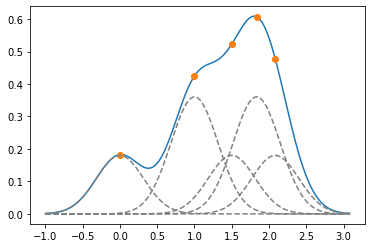

In [58]:
ax1=peaks1d.get_plot()

In [4]:
gmm1 = mixture.GaussianMixture(n_components=5, covariance_type='spherical', 
                               tol=1.e-8, max_iter=100000, warm_start=False)
gmm1.fit(sample1d)

GaussianMixture(covariance_type='spherical', max_iter=100000, n_components=5,
                tol=1e-08)

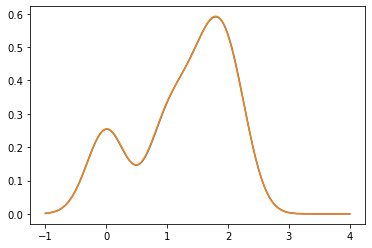

In [5]:
xgrid1d = numpy.linspace(-1,4,1000)
xgrid1d.shape = (-1,1)
target = peaks1d.pdf(xgrid1d)
pred = numpy.exp(gmm1.score_samples(xgrid1d))
plt.plot(xgrid1d, target, xgrid1d, pred)

### Deviation

In [9]:
class Deviation:
    
    def __init__(self, xgrid, target_distribution):
        self.xgrid = xgrid
        self.target_distribution = target_distribution
        self.target = target_distribution.pdf(xgrid)
        self._area = (self.xgrid.max(axis=0) - self.xgrid.min(axis=0)).prod()
        shape = list(self.xgrid.shape)
        shape.remove(1)
        self._n_elements = (numpy.array(shape)-1).prod()
        self._element_area = self._area/self._n_elements
        
    def _calc_deviation(self, model):
        pred = numpy.exp(model.score_samples(self.xgrid))
        diff = pred - target
        self.sigma2 = numpy.dot(diff, diff)*self._element_area
        self.sigma  = numpy.sqrt(self.sigma2)
        
    def __call__(self, model):
        self._calc_deviation(model)
        return self.sigma2

In [10]:
xgrid1d = numpy.linspace(-1,4,1000)
xgrid1d.shape = (-1,1)
deviation1d = Deviation(xgrid1d, peaks1d)
deviation1d(gmm1)

6.164617095237704e-05

In [11]:
def get_model_precision(n_components, sample):
    gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='spherical', 
                               tol=1.e-7, max_iter=10000, warm_start=False)
    gmm.fit(sample)
    dev = deviation1d(gmm)
    return gmm.aic(xgrid1d), gmm.bic(xgrid1d), gmm.score(xgrid1d), dev

In [12]:
precisions = [get_model_precision(i, sample1d) for i in range(1,10)]

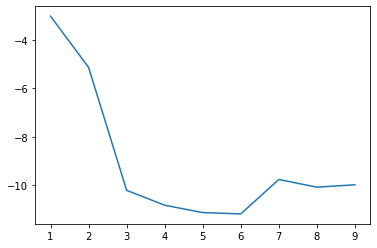

In [13]:
plt.plot(range(1,10), numpy.log(numpy.array(precisions)[:,-1]))

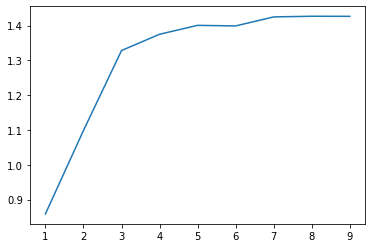

In [15]:
plt.plot(range(1,10), numpy.log(-numpy.array(precisions)[:,-2]))

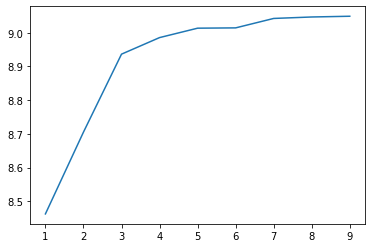

In [16]:
plt.plot(range(1,10), numpy.log(numpy.array(precisions)[:,-3]))

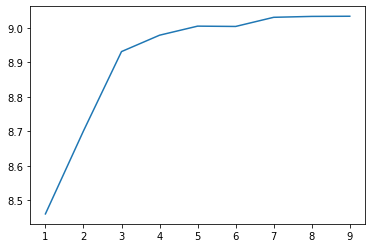

In [17]:
plt.plot(range(1,10), numpy.log(numpy.array(precisions)[:,-4]))

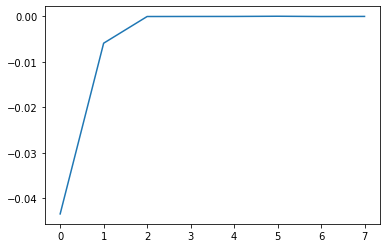

In [18]:
precisions = numpy.array(precisions)
diff = precisions[1:] - precisions[:-1]
plt.plot(diff[:,3])

## Bayesian

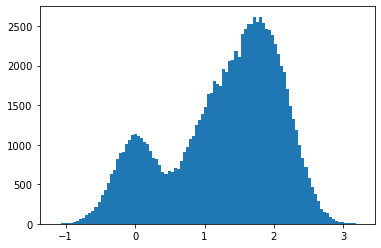

In [19]:
hist = plt.hist(sample1d, bins=100)

In [20]:
def bgm(wcp):
    return mixture.BayesianGaussianMixture(n_components=8, 
                                        max_iter=100000, 
                                        init_params='kmeans', 
                                        tol=0.001,
                                        weight_concentration_prior=wcp
                                        )

In [21]:
wcps = numpy.logspace(-3, 2,10)
wcps

array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02])

In [22]:
weights = {}
for wcp in wcps:
    mixmodel = bgm(wcp)
    mixmodel.fit(sample1d)
    weights[wcp] = mixmodel.weights_
    print(wcp, "DONE")

0.001 DONE
0.003593813663804626 DONE
0.01291549665014884 DONE
0.046415888336127795 DONE
0.1668100537200059 DONE
0.5994842503189409 DONE
2.1544346900318843 DONE
7.742636826811277 DONE
27.825594022071257 DONE
100.0 DONE


In [23]:
weights

{0.001: array([1.85863355e-01, 3.20018562e-01, 1.99726631e-01, 1.17511552e-01,
        1.76879889e-01, 9.98868115e-09, 9.97870244e-12, 9.96873371e-15]),
 0.003593813663804626: array([3.49793392e-01, 2.00702667e-01, 2.29539425e-01, 2.19964480e-01,
        3.58061097e-08, 1.28219689e-10, 4.59147579e-13, 1.64418196e-15]),
 0.01291549665014884: array([3.43976631e-01, 1.51849871e-05, 8.84675839e-02, 6.72798719e-02,
        1.98567693e-01, 1.24884141e-01, 4.10652109e-02, 1.35743683e-01]),
 0.046415888336127795: array([2.01034240e-01, 3.44048870e-01, 1.90705550e-01, 2.64210876e-01,
        4.43533451e-07, 1.96738212e-08, 8.72672042e-10, 3.87091294e-11]),
 0.1668100537200059: array([4.11192520e-01, 1.48415961e-05, 2.00393841e-01, 1.70113384e-01,
        3.52371973e-02, 1.83046578e-01, 1.43337745e-06, 2.04827464e-07]),
 0.5994842503189409: array([3.33903025e-01, 2.01049431e-01, 2.72568363e-01, 1.92472774e-01,
        4.12643176e-06, 1.50691473e-06, 5.62261745e-07, 2.10548498e-07]),
 2.154434690

### 2D

In [24]:
means2d = numpy.stack([means1d, means1d], axis=1)
covs2d = numpy.array(len(means1d)*[0.005*numpy.identity(2)])

peaks2d = Peaks(means2d, covs2d)
sample2d = peaks2d.rvs(10000)

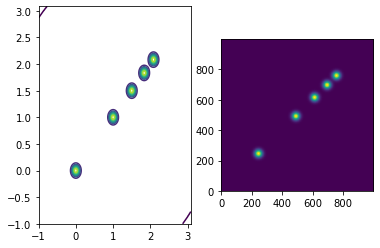

In [25]:
ax2d = peaks2d.get_plot()

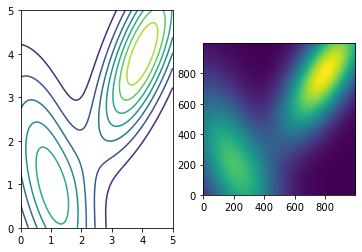

In [26]:
means2da = [[1.,1.], [4.,4.]]
covs2da = [ [[1.,-2],[-1,3.]] , [[1.,0.],[1.,2.]] ]
peaks2da = Peaks(means2da, covs2da)
ax2da = peaks2da.get_plot()

### 3D

In [27]:
means3d = numpy.stack(3*[means1d], axis=1)
covs3d = numpy.array(len(means1d)*[0.05*numpy.identity(3)])

peaks3d = Peaks(means3d, covs3d)
sample3d = peaks3d.rvs(10000)

## Fitting Gaussian Mixture Models with Expectation-Maximization

In [28]:
from sklearn import mixture

In [29]:
gmm1 = mixture.GaussianMixture(n_components=2, covariance_type='full')

In [30]:
from sklearn.mixture import gaussian_mixture, bayesian_mixture


/Users/thomasholmrod/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/thomasholmrod/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.bayesian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)



### Specific Instrument 

**SANS: **
*Comment:* It should be possible to show that in the limit of SANS, we only need to consider $\boldsymbol q$, i.e. that inelastic phenomena can be neglected or are integrated out.

SANS consider elastic scattering and is as such a diffraction technique. For elastic scattering the wave number $\omega$ is unambiguously given by the scattering vector $\boldsymbol q$.

**Reflectometry:**

**Powder and liquid diffraction:**
*1D:*
*2D:* 

**Laue diffraction:**
*2D:*
*3D:*

**Powder and liquid INS:**


**Single crystal INS:**



## Litterature review

Have not really been able to find something. Needs to find something "just" on peak integration.

*Search term:* clustering "peak integration"
**van Stee, L.L.P. & Brinkman, U.A.Th. (2016). *Peak detection methods for GC × GC: An overview. TrAC Trends in Analytical Chemistry.* 83. 10.1016/j.trac.2016.07.009.** The literature on methods for peak detection and integration for comprehensive two-dimensional gas chromatography (GC × GC) is reviewed with a focus on methods for the detection of individual peaks. These methods are of importance to make GC × GC generally applicable for identification and subsequent quantification of target compounds, and for non-target screening strategies, such as used in, e.g. food, biological, environmental and metabolomics studies, as well. There are three main groups of technique: methods based on 1D peak integration and subsequent automated clustering, multivariate methods and graphical methods. The principles, merits and demerits of each technique are discussed.



## Peak integration

## Kernel density estimation

## Clustering events
Many different algorithms exist for clustering data and it seems natural to test these methods on data that inherently are clustered.

In [31]:
import sklearn
import scipy
from scipy.stats import distributions